# 目的
これまでの解析で得られた手法を実際に実装してみたところ、期待される動きとは異なる解析をしていたようで、
どの(N1, N2)の組でも利益を上げることができないということが判明してしまった。   
このノートでは、実際の動きに合わせて実装されたクラスを使用し、得られたデータを改めて解析する。   
その上で、利確できる手法を見つけ出す。   

## 背景
Cross point や extreme point への到達が予想できないために、これまでその次のpointでorder/contractを行ってきた。   
しかしながら実際に実装してみると、解析の時点で誤った処理を行っていたことが判明した。   
さらに悪いことに、first extreme pointの次のpointでcontractを行うと利益が出ないことまで判明した。   

## import

In [3]:
import glob
from itertools import combinations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("../pybitcoin/gui/utils/")

from DataAdapter import DataAdapter

%matplotlib inline

## load dataset

In [4]:
file_list = glob.glob("../pybitcoin/gui/data/ohlcv/OHLCV*.csv")
data = None
for fpath in file_list:
    if data is None:
        data = pd.read_csv(fpath, index_col=0)
    else:
        data = pd.concat((data, pd.read_csv(fpath, index_col=0)))

## initialize an adapter

In [5]:
N_dec = 5
N1 = 20
N2 = 21
delta = 10.

今回はorderを出したcross point から 次の cross point でcontract/orderを行ってみる。

In [6]:
class DataAdapter2(DataAdapter):
    
    def __init__(self, **kwargs):
        """__init__(self, **kwargs) -> None
        
        initialize this class
        """
        super().__init__(**kwargs)
        
    def updateExecutionState(self):
        """updateExecutionState(self) -> None

        update the state of execution
        """
        if self._current_state == "wait":
            if self._cross_signal[-1] == 1.: # golden cross
                if self._golden_patterns is None or self._dec[-1] in self._golden_patterns:
                    self._current_state = "ask"
            if self._cross_signal[-1] == -1.: # dead cross
                if self._golden_patterns is None or self._dec[-1] in self._dead_patterns:
                    self._current_state = "bid"
        elif self._current_state == "sell":
            if self._cross_signal[-1] == -1.:
                self._current_state = "con"
        elif self._current_state == "buy":
            if self._cross_signal[-1] == 1.:
                self._current_state = "con"
        
    def orderProcess(self):
        """orderProcess(self) -> None

        process of order
        """
        if len(self._jpy_list) == 0:
            self._jpy_list.append(0)
        else:
            self._jpy_list.append(self._jpy_list[-1])
        self._benefit_list.append(0)
        # <debug>
        if self._ii == len(self._data_frame) - 1:
            return
        row = self._data_[self._ii + 1]
        # </debug>
        if self._benefit_timing == "worst":
            ltp_max = max([row[0], row[-1]])
            ltp_min = min([row[0], row[-1]])
        elif self._benefit_timing == "mean":
            ltp_max = int((row[0] + row[-1]) / 2)
            ltp_min = int((row[0] + row[-1]) / 2)
        elif self._benefit_timing == "open":
            ltp_max = row[0]
            ltp_min = row[0]
        else:
            raise ValueError
        if self._current_state == "ask": # order of "sell"
            self._order_ltp = ltp_max
            self._current_state = "sell"
            self._look_for_max = True
        elif self._current_state == "bid": # order of "buy"
            self._order_ltp = ltp_min
            self._current_state = "buy"
            self._look_for_max = False
        elif self._current_state == "con":
            # when the previous state is "sell"
            ## a dead cross point reaches before the first extreme maximum point
            if self._cross_signal[-1] == -1.:
                # order of "sell"
                ltp_ = ltp_min
                self._jpy_list[-1] += ltp_ - self._order_ltp
                self._benefit_list[-1] += ltp_ - self._order_ltp
                self._stop_by_cross = 0

                # go to bid and order immediately
                self._order_ltp = ltp_min
                self._current_state = "buy"
                self._look_for_max = False

            # when the previous state is "buy"
            ## a golden cross point reaches before the first extreme minimum point
            elif self._cross_signal[-1] == 1.:
                # order of "buy"
                ltp_ = ltp_max
                self._jpy_list[-1] -= ltp_ - self._order_ltp
                self._benefit_list[-1] -= ltp_ - self._order_ltp
                self._stop_by_cross = 0

                # go to ask and order immediately
                self._order_ltp = ltp_max
                self._current_state = "sell"
                self._look_for_max = True
        else:
            return

In [7]:
ad = DataAdapter(data, N_ema_max=20, N_ema_min=1, N_dec=N_dec, N_ema1=N1, N_ema2=N2, delta=delta, size=1.0,)
ad2 = DataAdapter2(df=data, N_ema_max=20, N_ema_min=1, N_dec=N_dec, N_ema1=N1, N_ema2=N2, delta=delta, size=1.0,)

[2019-01-28 01:28:06,614] (DEBUG) >> initOHLCVData()
[2019-01-28 01:28:13,151] (DEBUG) << initOHLCVData()
[2019-01-28 01:28:13,151] (DEBUG) >> initAnalysisData()
[2019-01-28 01:28:13,161] (DEBUG) << initAnalysisData()
[2019-01-28 01:28:13,169] (DEBUG) >> initOHLCVData()
[2019-01-28 01:28:18,965] (DEBUG) << initOHLCVData()
[2019-01-28 01:28:18,977] (DEBUG) >> initAnalysisData()
[2019-01-28 01:28:18,984] (DEBUG) << initAnalysisData()


In [8]:
ad.jpy_list[-1], ad2.jpy_list[-1]

(-94709, -138023)

In [9]:
np.array(ad._benefit_list)[np.array(ad._benefit_list)>=0].sum(), np.array(ad2._benefit_list)[np.array(ad2._benefit_list)>=0].sum()

(267626, 324427)

worstの場合でも、マイナスを除けばプラスになる。。

In [32]:
res = []
for ii, kk in combinations(np.arange(1, 21), 2):
    ad.N_ema1 = ii
    ad.N_ema2 = kk
    ad.initOHLCVData()
    
    ad2.N_ema1 = ii
    ad2.N_ema2 = kk
    ad2.initOHLCVData()
    res.append([ii, kk, ad.jpy_list[-1], ad2.jpy_list[-1]])

[2019-01-27 22:08:28,015] (DEBUG) >> initOHLCVData()
[2019-01-27 22:08:31,496] (DEBUG) << initOHLCVData()
[2019-01-27 22:08:31,496] (DEBUG) >> initOHLCVData()
[2019-01-27 22:08:35,162] (DEBUG) << initOHLCVData()
[2019-01-27 22:08:35,162] (DEBUG) >> initOHLCVData()
[2019-01-27 22:08:38,526] (DEBUG) << initOHLCVData()
[2019-01-27 22:08:38,526] (DEBUG) >> initOHLCVData()
[2019-01-27 22:08:41,987] (DEBUG) << initOHLCVData()
[2019-01-27 22:08:41,987] (DEBUG) >> initOHLCVData()
[2019-01-27 22:08:45,287] (DEBUG) << initOHLCVData()
[2019-01-27 22:08:45,287] (DEBUG) >> initOHLCVData()
[2019-01-27 22:08:48,591] (DEBUG) << initOHLCVData()
[2019-01-27 22:08:48,591] (DEBUG) >> initOHLCVData()
[2019-01-27 22:08:51,937] (DEBUG) << initOHLCVData()
[2019-01-27 22:08:51,941] (DEBUG) >> initOHLCVData()
[2019-01-27 22:08:55,208] (DEBUG) << initOHLCVData()
[2019-01-27 22:08:55,216] (DEBUG) >> initOHLCVData()
[2019-01-27 22:08:58,482] (DEBUG) << initOHLCVData()
[2019-01-27 22:08:58,482] (DEBUG) >> initOHLCV

[2019-01-27 22:12:41,676] (DEBUG) << initOHLCVData()
[2019-01-27 22:12:41,678] (DEBUG) >> initOHLCVData()
[2019-01-27 22:12:44,841] (DEBUG) << initOHLCVData()
[2019-01-27 22:12:44,841] (DEBUG) >> initOHLCVData()
[2019-01-27 22:12:48,023] (DEBUG) << initOHLCVData()
[2019-01-27 22:12:48,031] (DEBUG) >> initOHLCVData()
[2019-01-27 22:12:51,161] (DEBUG) << initOHLCVData()
[2019-01-27 22:12:51,161] (DEBUG) >> initOHLCVData()
[2019-01-27 22:12:54,676] (DEBUG) << initOHLCVData()
[2019-01-27 22:12:54,678] (DEBUG) >> initOHLCVData()
[2019-01-27 22:12:57,758] (DEBUG) << initOHLCVData()
[2019-01-27 22:12:57,758] (DEBUG) >> initOHLCVData()
[2019-01-27 22:13:01,001] (DEBUG) << initOHLCVData()
[2019-01-27 22:13:01,003] (DEBUG) >> initOHLCVData()
[2019-01-27 22:13:04,073] (DEBUG) << initOHLCVData()
[2019-01-27 22:13:04,073] (DEBUG) >> initOHLCVData()
[2019-01-27 22:13:07,286] (DEBUG) << initOHLCVData()
[2019-01-27 22:13:07,286] (DEBUG) >> initOHLCVData()
[2019-01-27 22:13:10,415] (DEBUG) << initOHLCV

[2019-01-27 22:16:46,772] (DEBUG) >> initOHLCVData()
[2019-01-27 22:16:49,954] (DEBUG) << initOHLCVData()
[2019-01-27 22:16:49,954] (DEBUG) >> initOHLCVData()
[2019-01-27 22:16:53,063] (DEBUG) << initOHLCVData()
[2019-01-27 22:16:53,073] (DEBUG) >> initOHLCVData()
[2019-01-27 22:16:56,184] (DEBUG) << initOHLCVData()
[2019-01-27 22:16:56,184] (DEBUG) >> initOHLCVData()
[2019-01-27 22:16:59,273] (DEBUG) << initOHLCVData()
[2019-01-27 22:16:59,273] (DEBUG) >> initOHLCVData()
[2019-01-27 22:17:02,422] (DEBUG) << initOHLCVData()
[2019-01-27 22:17:02,422] (DEBUG) >> initOHLCVData()
[2019-01-27 22:17:05,533] (DEBUG) << initOHLCVData()
[2019-01-27 22:17:05,541] (DEBUG) >> initOHLCVData()
[2019-01-27 22:17:08,677] (DEBUG) << initOHLCVData()
[2019-01-27 22:17:08,688] (DEBUG) >> initOHLCVData()
[2019-01-27 22:17:11,757] (DEBUG) << initOHLCVData()
[2019-01-27 22:17:11,757] (DEBUG) >> initOHLCVData()
[2019-01-27 22:17:14,954] (DEBUG) << initOHLCVData()
[2019-01-27 22:17:14,958] (DEBUG) >> initOHLCV

[2019-01-27 22:20:53,327] (DEBUG) << initOHLCVData()
[2019-01-27 22:20:53,329] (DEBUG) >> initOHLCVData()
[2019-01-27 22:20:56,480] (DEBUG) << initOHLCVData()
[2019-01-27 22:20:56,488] (DEBUG) >> initOHLCVData()
[2019-01-27 22:20:59,618] (DEBUG) << initOHLCVData()
[2019-01-27 22:20:59,628] (DEBUG) >> initOHLCVData()
[2019-01-27 22:21:02,775] (DEBUG) << initOHLCVData()
[2019-01-27 22:21:02,777] (DEBUG) >> initOHLCVData()
[2019-01-27 22:21:05,814] (DEBUG) << initOHLCVData()
[2019-01-27 22:21:05,814] (DEBUG) >> initOHLCVData()
[2019-01-27 22:21:09,015] (DEBUG) << initOHLCVData()
[2019-01-27 22:21:09,017] (DEBUG) >> initOHLCVData()
[2019-01-27 22:21:12,074] (DEBUG) << initOHLCVData()
[2019-01-27 22:21:12,085] (DEBUG) >> initOHLCVData()
[2019-01-27 22:21:15,234] (DEBUG) << initOHLCVData()
[2019-01-27 22:21:15,236] (DEBUG) >> initOHLCVData()
[2019-01-27 22:21:18,346] (DEBUG) << initOHLCVData()
[2019-01-27 22:21:18,354] (DEBUG) >> initOHLCVData()
[2019-01-27 22:21:21,500] (DEBUG) << initOHLCV

[2019-01-27 22:24:57,364] (DEBUG) >> initOHLCVData()
[2019-01-27 22:25:00,485] (DEBUG) << initOHLCVData()
[2019-01-27 22:25:00,485] (DEBUG) >> initOHLCVData()
[2019-01-27 22:25:03,597] (DEBUG) << initOHLCVData()
[2019-01-27 22:25:03,597] (DEBUG) >> initOHLCVData()
[2019-01-27 22:25:06,700] (DEBUG) << initOHLCVData()
[2019-01-27 22:25:06,700] (DEBUG) >> initOHLCVData()
[2019-01-27 22:25:09,871] (DEBUG) << initOHLCVData()
[2019-01-27 22:25:09,881] (DEBUG) >> initOHLCVData()
[2019-01-27 22:25:13,114] (DEBUG) << initOHLCVData()
[2019-01-27 22:25:13,125] (DEBUG) >> initOHLCVData()
[2019-01-27 22:25:16,215] (DEBUG) << initOHLCVData()
[2019-01-27 22:25:16,223] (DEBUG) >> initOHLCVData()
[2019-01-27 22:25:19,315] (DEBUG) << initOHLCVData()
[2019-01-27 22:25:19,318] (DEBUG) >> initOHLCVData()
[2019-01-27 22:25:22,454] (DEBUG) << initOHLCVData()
[2019-01-27 22:25:22,456] (DEBUG) >> initOHLCVData()
[2019-01-27 22:25:25,536] (DEBUG) << initOHLCVData()
[2019-01-27 22:25:25,536] (DEBUG) >> initOHLCV

In [34]:
for row in res:
    print(row)

[1, 2, -1842935, -1859700]
[1, 3, -1558969, -1556886]
[1, 4, -1350142, -1357762]
[1, 5, -1171352, -1186185]
[1, 6, -1066889, -1060125]
[1, 7, -977529, -973809]
[1, 8, -923080, -915159]
[1, 9, -876232, -867707]
[1, 10, -816231, -806203]
[1, 11, -770966, -758263]
[1, 12, -734051, -729597]
[1, 13, -694661, -688553]
[1, 14, -672824, -675751]
[1, 15, -648022, -649949]
[1, 16, -621202, -613929]
[1, 17, -605313, -602325]
[1, 18, -584025, -584303]
[1, 19, -565310, -562215]
[1, 20, -562435, -560529]
[2, 3, -1103856, -1126757]
[2, 4, -965089, -966479]
[2, 5, -857658, -869521]
[2, 6, -751559, -753701]
[2, 7, -694243, -696615]
[2, 8, -635332, -627123]
[2, 9, -603480, -596067]
[2, 10, -564086, -566445]
[2, 11, -548664, -553419]
[2, 12, -537356, -542724]
[2, 13, -512517, -511492]
[2, 14, -494062, -492306]
[2, 15, -481867, -478728]
[2, 16, -470992, -478086]
[2, 17, -440620, -444514]
[2, 18, -426990, -426906]
[2, 19, -418717, -418964]
[2, 20, -415952, -416912]
[3, 4, -761940, -779321]
[3, 5, -687172, 

Cross pointまで待つよりは最初のピークで約定したほうが良いときもあればそうでないときもある。。

## Open, meanで計算した場合

In [10]:
ad.benefit_timing = "worst"
ad2.benefit_timing = "worst"
ad._ema_update = True
ad2._ema_update = True
ad.initOHLCVData()
ad2.initOHLCVData()
print("worst:", ad.jpy_list[-1], ad2.jpy_list[-1])

ad.benefit_timing = "open"
ad2.benefit_timing = "open"
ad._ema_update = True
ad2._ema_update = True
ad.initOHLCVData()
ad2.initOHLCVData()
print("open:", ad.jpy_list[-1], ad2.jpy_list[-1])

ad.benefit_timing = "mean"
ad2.benefit_timing = "mean"
ad._ema_update = True
ad2._ema_update = True
ad.initOHLCVData()
ad2.initOHLCVData()
print("mean:", ad.jpy_list[-1], ad2.jpy_list[-1])

[2019-01-27 22:59:20,617] (DEBUG) >> initOHLCVData()
[2019-01-27 22:59:25,675] (DEBUG) << initOHLCVData()
[2019-01-27 22:59:25,675] (DEBUG) >> initOHLCVData()
[2019-01-27 22:59:30,602] (DEBUG) << initOHLCVData()
[2019-01-27 22:59:30,602] (DEBUG) >> initOHLCVData()


worst: -94709 -138023


[2019-01-27 22:59:35,352] (DEBUG) << initOHLCVData()
[2019-01-27 22:59:35,354] (DEBUG) >> initOHLCVData()
[2019-01-27 22:59:40,001] (DEBUG) << initOHLCVData()
[2019-01-27 22:59:40,009] (DEBUG) >> initOHLCVData()


open: 44751 472


[2019-01-27 22:59:45,031] (DEBUG) << initOHLCVData()
[2019-01-27 22:59:45,041] (DEBUG) >> initOHLCVData()
[2019-01-27 22:59:50,671] (DEBUG) << initOHLCVData()


mean: 60686 16740


In [12]:
ad.benefit_timing = "mean"
ad2.benefit_timing = "mean"
print("ad")
ad.ana_update = True
ad.initAnalysisData()
print("ad2")
ad2.ana_update = True
ad2.initAnalysisData()

[2019-01-27 23:02:43,313] (DEBUG) >> initAnalysisData()


ad


[2019-01-27 23:02:46,116] (DEBUG) >> initOHLCVData()
[2019-01-27 23:02:49,775] (DEBUG) << initOHLCVData()
[2019-01-27 23:02:57,474] (DEBUG) >> initOHLCVData()
[2019-01-27 23:03:01,222] (DEBUG) << initOHLCVData()
[2019-01-27 23:03:07,391] (DEBUG) >> initOHLCVData()
[2019-01-27 23:03:11,232] (DEBUG) << initOHLCVData()
[2019-01-27 23:03:16,546] (DEBUG) >> initOHLCVData()
[2019-01-27 23:03:20,213] (DEBUG) << initOHLCVData()
[2019-01-27 23:03:24,773] (DEBUG) >> initOHLCVData()
[2019-01-27 23:03:28,479] (DEBUG) << initOHLCVData()
[2019-01-27 23:03:32,368] (DEBUG) >> initOHLCVData()
[2019-01-27 23:03:36,018] (DEBUG) << initOHLCVData()
[2019-01-27 23:03:39,858] (DEBUG) >> initOHLCVData()
[2019-01-27 23:03:43,372] (DEBUG) << initOHLCVData()
[2019-01-27 23:03:46,959] (DEBUG) >> initOHLCVData()
[2019-01-27 23:03:50,799] (DEBUG) << initOHLCVData()
[2019-01-27 23:03:54,196] (DEBUG) >> initOHLCVData()
[2019-01-27 23:03:58,115] (DEBUG) << initOHLCVData()
[2019-01-27 23:04:01,321] (DEBUG) >> initOHLCV

[2019-01-27 23:10:07,395] (DEBUG) << initOHLCVData()
[2019-01-27 23:10:08,464] (DEBUG) >> initOHLCVData()
[2019-01-27 23:10:12,002] (DEBUG) << initOHLCVData()
[2019-01-27 23:10:13,022] (DEBUG) >> initOHLCVData()
[2019-01-27 23:10:16,547] (DEBUG) << initOHLCVData()
[2019-01-27 23:10:17,527] (DEBUG) >> initOHLCVData()
[2019-01-27 23:10:21,060] (DEBUG) << initOHLCVData()
[2019-01-27 23:10:22,031] (DEBUG) >> initOHLCVData()
[2019-01-27 23:10:25,512] (DEBUG) << initOHLCVData()
[2019-01-27 23:10:26,444] (DEBUG) >> initOHLCVData()
[2019-01-27 23:10:29,907] (DEBUG) << initOHLCVData()
[2019-01-27 23:10:30,825] (DEBUG) >> initOHLCVData()
[2019-01-27 23:10:34,367] (DEBUG) << initOHLCVData()
[2019-01-27 23:10:35,194] (DEBUG) >> initOHLCVData()
[2019-01-27 23:10:38,699] (DEBUG) << initOHLCVData()
[2019-01-27 23:10:39,536] (DEBUG) >> initOHLCVData()
[2019-01-27 23:10:43,049] (DEBUG) << initOHLCVData()
[2019-01-27 23:10:44,393] (DEBUG) >> initOHLCVData()
[2019-01-27 23:10:47,865] (DEBUG) << initOHLCV

[2019-01-27 23:15:49,111] (DEBUG) >> initOHLCVData()
[2019-01-27 23:15:52,855] (DEBUG) << initOHLCVData()
[2019-01-27 23:15:53,686] (DEBUG) >> initOHLCVData()
[2019-01-27 23:15:57,379] (DEBUG) << initOHLCVData()
[2019-01-27 23:15:58,088] (DEBUG) >> initOHLCVData()
[2019-01-27 23:16:01,836] (DEBUG) << initOHLCVData()
[2019-01-27 23:16:02,503] (DEBUG) >> initOHLCVData()
[2019-01-27 23:16:06,207] (DEBUG) << initOHLCVData()
[2019-01-27 23:16:06,905] (DEBUG) >> initOHLCVData()
[2019-01-27 23:16:10,387] (DEBUG) << initOHLCVData()
[2019-01-27 23:16:11,033] (DEBUG) >> initOHLCVData()
[2019-01-27 23:16:14,588] (DEBUG) << initOHLCVData()
[2019-01-27 23:16:15,173] (DEBUG) >> initOHLCVData()
[2019-01-27 23:16:18,760] (DEBUG) << initOHLCVData()
[2019-01-27 23:16:19,334] (DEBUG) >> initOHLCVData()
[2019-01-27 23:16:22,911] (DEBUG) << initOHLCVData()
[2019-01-27 23:16:23,619] (DEBUG) >> initOHLCVData()
[2019-01-27 23:16:27,090] (DEBUG) << initOHLCVData()
[2019-01-27 23:16:27,768] (DEBUG) >> initOHLCV

ad2


[2019-01-27 23:18:20,655] (DEBUG) >> initOHLCVData()
[2019-01-27 23:18:24,375] (DEBUG) << initOHLCVData()
[2019-01-27 23:18:31,316] (DEBUG) >> initOHLCVData()
[2019-01-27 23:18:35,078] (DEBUG) << initOHLCVData()
[2019-01-27 23:18:40,881] (DEBUG) >> initOHLCVData()
[2019-01-27 23:18:44,650] (DEBUG) << initOHLCVData()
[2019-01-27 23:18:49,531] (DEBUG) >> initOHLCVData()
[2019-01-27 23:18:53,198] (DEBUG) << initOHLCVData()
[2019-01-27 23:18:57,667] (DEBUG) >> initOHLCVData()
[2019-01-27 23:19:01,655] (DEBUG) << initOHLCVData()
[2019-01-27 23:19:05,542] (DEBUG) >> initOHLCVData()
[2019-01-27 23:19:09,291] (DEBUG) << initOHLCVData()
[2019-01-27 23:19:13,002] (DEBUG) >> initOHLCVData()
[2019-01-27 23:19:16,667] (DEBUG) << initOHLCVData()
[2019-01-27 23:19:20,154] (DEBUG) >> initOHLCVData()
[2019-01-27 23:19:23,776] (DEBUG) << initOHLCVData()
[2019-01-27 23:19:26,805] (DEBUG) >> initOHLCVData()
[2019-01-27 23:19:30,489] (DEBUG) << initOHLCVData()
[2019-01-27 23:19:33,270] (DEBUG) >> initOHLCV

[2019-01-27 23:25:46,855] (DEBUG) << initOHLCVData()
[2019-01-27 23:25:47,958] (DEBUG) >> initOHLCVData()
[2019-01-27 23:25:51,896] (DEBUG) << initOHLCVData()
[2019-01-27 23:25:52,928] (DEBUG) >> initOHLCVData()
[2019-01-27 23:25:56,826] (DEBUG) << initOHLCVData()
[2019-01-27 23:25:57,745] (DEBUG) >> initOHLCVData()
[2019-01-27 23:26:01,541] (DEBUG) << initOHLCVData()
[2019-01-27 23:26:02,594] (DEBUG) >> initOHLCVData()
[2019-01-27 23:26:06,422] (DEBUG) << initOHLCVData()
[2019-01-27 23:26:07,363] (DEBUG) >> initOHLCVData()
[2019-01-27 23:26:10,948] (DEBUG) << initOHLCVData()
[2019-01-27 23:26:11,929] (DEBUG) >> initOHLCVData()
[2019-01-27 23:26:15,534] (DEBUG) << initOHLCVData()
[2019-01-27 23:26:16,466] (DEBUG) >> initOHLCVData()
[2019-01-27 23:26:20,083] (DEBUG) << initOHLCVData()
[2019-01-27 23:26:20,902] (DEBUG) >> initOHLCVData()
[2019-01-27 23:26:24,632] (DEBUG) << initOHLCVData()
[2019-01-27 23:26:25,943] (DEBUG) >> initOHLCVData()
[2019-01-27 23:26:29,628] (DEBUG) << initOHLCV

[2019-01-27 23:31:39,542] (DEBUG) >> initOHLCVData()
[2019-01-27 23:31:43,155] (DEBUG) << initOHLCVData()
[2019-01-27 23:31:43,814] (DEBUG) >> initOHLCVData()
[2019-01-27 23:31:47,550] (DEBUG) << initOHLCVData()
[2019-01-27 23:31:48,189] (DEBUG) >> initOHLCVData()
[2019-01-27 23:31:52,152] (DEBUG) << initOHLCVData()
[2019-01-27 23:31:52,912] (DEBUG) >> initOHLCVData()
[2019-01-27 23:31:56,753] (DEBUG) << initOHLCVData()
[2019-01-27 23:31:57,432] (DEBUG) >> initOHLCVData()
[2019-01-27 23:32:01,078] (DEBUG) << initOHLCVData()
[2019-01-27 23:32:01,775] (DEBUG) >> initOHLCVData()
[2019-01-27 23:32:05,678] (DEBUG) << initOHLCVData()
[2019-01-27 23:32:06,264] (DEBUG) >> initOHLCVData()
[2019-01-27 23:32:09,933] (DEBUG) << initOHLCVData()
[2019-01-27 23:32:10,518] (DEBUG) >> initOHLCVData()
[2019-01-27 23:32:14,237] (DEBUG) << initOHLCVData()
[2019-01-27 23:32:14,893] (DEBUG) >> initOHLCVData()
[2019-01-27 23:32:18,466] (DEBUG) << initOHLCVData()
[2019-01-27 23:32:19,287] (DEBUG) >> initOHLCV

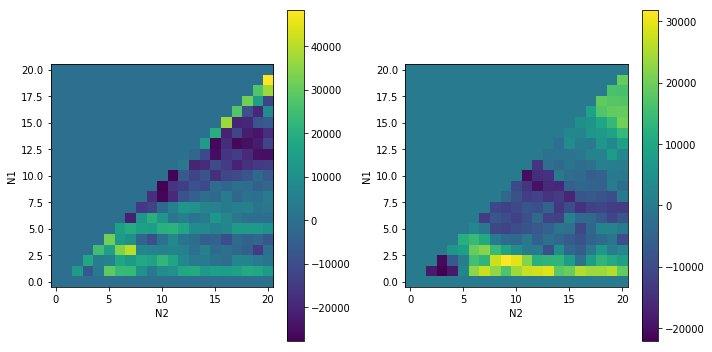

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(ad.benefit_map, origin="normal")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()

plt.subplot(122)
plt.imshow(ad2.benefit_map, origin="normal")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()

plt.tight_layout()

meanで計算しても、あるリージョンに利確の組み合わせが集まっているとはいいがたい。

In [53]:
np.array(ad._benefit_list)[np.array(ad._benefit_list)>=0].sum(), np.array(ad2._benefit_list)[np.array(ad2._benefit_list)>=0].sum()

(267626, 324427)

利確の部分だけを取り出すと、十分な利益が望めそう。   
どうやってこれを取り出せるか？

## decimal, volume との相関
抜き出した decimal や volume と、利益のプラス・マイナスの間に相関があるかどうか調べる。

In [10]:
cross_signal = np.array(ad2.cross_signal)
benefit_list = np.array(ad2._benefit_list)
dec = np.array(ad2._dec)
volumes = np.array(ad2.volume_list)

In [11]:
(cross_signal != 0).sum(), (benefit_list != 0).sum()

(1208, 1206)

理想的には、cross signal の数に対してbenefit listの数は２つ少ない。   
これはcross signalのうち最初と最後についてはbenefitが与えられないから。   
Extreme point の場合、benefit list に入っているノンゼロの数が少ない。   
つまり現行のDataAdapterにはバグがあり、別途修正が必要（解析に対して影響はあるが、現状ではcross pointのケースでの解析で十分試せる）。

In [12]:
benefit_golden = np.zeros(len(cross_signal))
benefit_dead = np.zeros(len(cross_signal))
for jj in range(len(cross_signal)):
    if cross_signal[jj] == 1: # golden case
        buff = benefit_list[jj+1:]
        # buff2 = np.array(self._extreme_signal[jj:], dtype=float)
        # v = buff[np.where(buff2 == 1.)[0][0] + 1]
        ind = buff != 0
        if ind.sum() != 0:
            v = buff[buff != 0][0]
        else:
            v = 0
        benefit_golden[jj] = v
    elif cross_signal[jj] == -1: # dead case
        buff = benefit_list[jj+1:]
        # buff2 = np.array(self._extreme_signal[jj:], dtype=float)
        # v = buff[np.where(buff2 == -1.)[0][0] + 1]
        ind = buff != 0
        if ind.sum() != 0:
            v = buff[buff != 0][0]
        else:
            v = 0
        benefit_dead[jj] = v

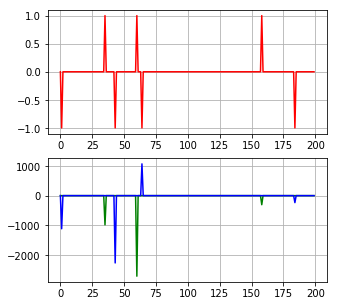

In [54]:
plt.figure(figsize=(5, 5))
plt.subplot(211)
plt.plot(cross_signal[:200], "r")
plt.grid(True)

plt.subplot(212)
plt.plot(benefit_golden[:200], "g")
plt.plot(benefit_dead[:200], "b")
plt.grid(True)

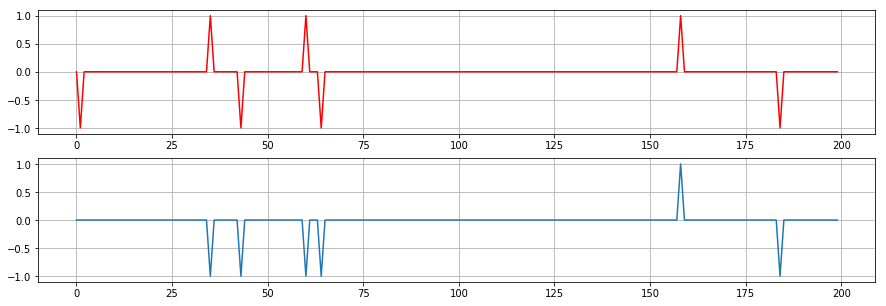

In [55]:
plt.figure(figsize=(15, 5))
plt.subplot(211)
plt.plot(cross_signal[0:200], "r")
plt.grid(True)

plt.subplot(212)
plt.plot(((benefit_list != 0)*np.sign(benefit_list))[0:200])
plt.grid(True)

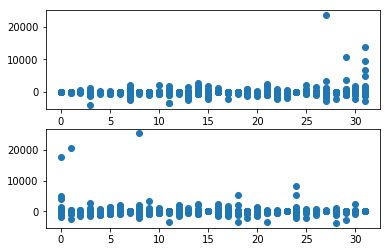

In [60]:
plt.figure()
plt.subplot(211)
plt.plot(dec[cross_signal != 0], benefit_golden[cross_signal != 0], "o")

plt.subplot(212)
plt.plot(dec[cross_signal != 0], benefit_dead[cross_signal != 0], "o")

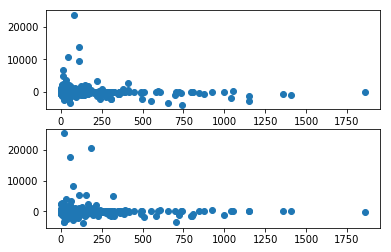

In [61]:
plt.figure()
plt.subplot(211)
plt.plot(volumes[cross_signal != 0], benefit_golden[cross_signal != 0], "o")

plt.subplot(212)
plt.plot(volumes[cross_signal != 0], benefit_dead[cross_signal != 0], "o")

以前に解析したときと同様、decimal patters と相関が見られない。   
また、volumeとも相関が見られない。

## 3D plot

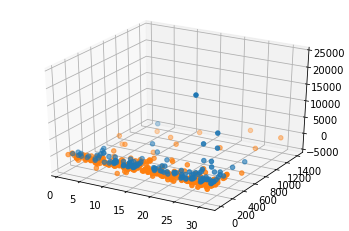

In [17]:
# %matplotlib
plt.figure()
ax = plt.subplot(111, projection="3d")
ind = (cross_signal != 0) & (benefit_golden > 0)
ind2 = (cross_signal != 0) & (benefit_golden < 0)
ax.scatter(dec[ind], volumes[ind], benefit_golden[ind], "o")
ax.scatter(dec[ind2], volumes[ind2], benefit_golden[ind2], "ro")

# plt.view_init()
plt.show()
# plt.scatter()

In [ ]:
dec_list = 